## Setup

In [1]:
# Install compatible versions of required packages
!pip install --no-cache-dir --force-reinstall numpy==1.26.4
!pip install --no-cache-dir pandas matplotlib seaborn scikit-learn tqdm
!pip install --no-cache-dir umap-learn hdbscan
!pip install --no-cache-dir gensim tensorflow
!pip install --no-cache-dir sentence-transformers
!pip install --no-cache-dir bertopic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 256.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 200.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 219.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 297.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 302.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 301.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 

In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.manifold import TSNE
from gensim.models.coherencemodel import CoherenceModel
import gensim.corpora as corpora
from tqdm.auto import tqdm
import json
from datetime import datetime
from pathlib import Path
from typing import List, Dict, Tuple, Any, Optional
import random
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# UMAP for dimensionality reduction
import umap

# HDBSCAN for clustering
import hdbscan

# BERTopic and sentence transformers
import bertopic
from bertopic import BERTopic

In [2]:
# Mount Google Drive to access saved embeddings
from google.colab import drive
drive.mount('/content/drive')

# Define output and data directories
PROJECT_DIR = '/content/drive/MyDrive/MIDS/W266/final_project/'
EMBEDDING_DIR = f"{PROJECT_DIR}/embeddings/"
OUTPUT_DIR = f"{PROJECT_DIR}/results/"
FIGURE_DIR = f"{PROJECT_DIR}/figures/evaluation/"

# Ensure directories exist
for directory in [OUTPUT_DIR, FIGURE_DIR]:
    os.makedirs(directory, exist_ok=True)

Mounted at /content/drive


## Load data

In [3]:
# Helper function to load embeddings and document data
def load_data():
    """
    Load saved embeddings and document metadata

    Returns:
        dict: Dictionary containing embeddings and document information
    """
    print("Loading embeddings and document data...")

    # Load document information
    docs_df = pd.read_csv(f"{EMBEDDING_DIR}/document_info.csv")

    # Load TopicWeave embeddings
    topicweave_embeddings = np.load(f"{EMBEDDING_DIR}/topicweave_embeddings.npy")
    scibert_embeddings = np.load(f"{EMBEDDING_DIR}/scibert_embeddings.npy")
    citation_embeddings = np.load(f"{EMBEDDING_DIR}/citation_embeddings.npy")

    # Load metadata
    with open(f"{EMBEDDING_DIR}/embeddings_metadata.json", "r") as f:
        metadata = json.load(f)

    print(f"Loaded {len(docs_df)} documents")
    print(f"TopicWeave embeddings shape: {topicweave_embeddings.shape}")
    print(f"SciBERT weight: {metadata['scibert_weight']}, Citation weight: {metadata['citation_model_weight']}")

    return {
        "docs_df": docs_df,
        "topicweave_embeddings": topicweave_embeddings,
        "scibert_embeddings": scibert_embeddings,
        "citation_embeddings": citation_embeddings,
        "metadata": metadata
    }

## Create custom BERTopic model using TopicWeave embeddings

In [4]:
def create_custom_bertopic(embeddings, texts=None, min_topic_size=10, umap_components=5,
                          umap_neighbors=15, hdbscan_min_samples=10):
    """
    Create a custom BERTopic model using pre-computed embeddings

    Args:
        embeddings: Pre-computed document embeddings
        texts: Document texts (optional, for topic representation)
        min_topic_size: Minimum size of a topic
        umap_components: Number of UMAP components
        umap_neighbors: Number of neighbors for UMAP
        hdbscan_min_samples: Minimum samples for HDBSCAN

    Returns:
        BERTopic model
    """
    # Create a UMAP model
    import umap
    umap_model = umap.UMAP(
        n_components=umap_components,
        n_neighbors=umap_neighbors,
        min_dist=0.0,
        metric='cosine',
        random_state=42
    )

    # Create an HDBSCAN model
    import hdbscan
    hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=min_topic_size,
        min_samples=hdbscan_min_samples,
        metric='euclidean',
        prediction_data=True
    )

    # Create BERTopic model
    topic_model = BERTopic(
        embedding_model=None,  # No embedding model since we already have embeddings
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        verbose=True
    )

    return topic_model

## Evaluate quantitative metrics

In [5]:
# Evaluate BERTopic quantitative metrics
def evaluate_bertopic_quantitative(topics, categories):
    """
    Evaluate BERTopic results using quantitative metrics

    Args:
        topics: Generated topic assignments
        categories: Ground truth categories

    Returns:
        dict: Dictionary with evaluation metrics
    """
    # Calculate Normalized Mutual Information (NMI)
    nmi = normalized_mutual_info_score(categories, topics)

    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(categories, topics)

    # Count unique topics and categories
    n_topics = len(set([t for t in topics if t != -1]))  # Exclude outlier topic
    n_categories = len(set(categories))

    return {
        "NMI": nmi,
        "ARI": ari,
        "n_topics": n_topics,
        "n_categories": n_categories
    }

## Evaluate qualitative metrics

In [6]:
# Evaluate BERTopic qualitative metrics
def evaluate_bertopic_qualitative(topic_model, topics, texts):
    """
    Evaluate BERTopic results using qualitative metrics (coherence)

    Args:
        topic_model: Trained BERTopic model
        topics: Generated topic assignments
        texts: Document texts

    Returns:
        dict: Dictionary with coherence metrics
    """
    def simple_preprocess(text):
        """Simple text preprocessing for coherence calculation"""
        if isinstance(text, str):
            tokens = text.lower().split()
            return [token for token in tokens if len(token) > 2]
        return text

    # Create dictionary and corpus
    print("Building dictionary and corpus...")
    tokenized_texts = [simple_preprocess(text) for text in texts]
    dictionary = corpora.Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

    # Get unique topics (excluding outliers)
    unique_topics = [t for t in set(topics) if t != -1]
    print(f"Analyzing {len(unique_topics)} unique topics (excluding outliers)")

    # Get topic words
    topic_words = []
    skipped_topics = 0
    for topic_id in unique_topics:
        try:
            words = [word for word, _ in topic_model.get_topic(topic_id)][:10]
            topic_words.append(words)
        except Exception as e:
            print(f"Error getting topic words for topic {topic_id}: {e}")
            skipped_topics += 1

    print(f"Successfully extracted words for {len(topic_words)} topics (skipped {skipped_topics})")

    if not topic_words:
        print("No valid topics to analyze. Cannot calculate coherence.")
        return {"C_v Coherence": None, "NPMI Coherence": None}

    coherence_results = {}
    try:
        # Calculate C_v coherence
        cv_model = CoherenceModel(topics=topic_words, texts=tokenized_texts,
                                 dictionary=dictionary, coherence='c_v')
        coherence_results["C_v Coherence"] = cv_model.get_coherence()
    except Exception as e:
        print(f"Error calculating C_v coherence: {e}")
        coherence_results["C_v Coherence"] = None

    try:
        # Calculate NPMI coherence
        print("Calculating NPMI coherence...")
        npmi_model = CoherenceModel(topics=topic_words, texts=tokenized_texts,
                                   dictionary=dictionary, coherence='c_npmi')
        coherence_results["NPMI Coherence"] = npmi_model.get_coherence()
    except Exception as e:
        print(f"Error calculating NPMI coherence: {e}")
        coherence_results["NPMI Coherence"] = None

    return coherence_results

## Visualizations

In [7]:
# Create topic-category distribution visualization
def plot_topic_category_distribution(topics, categories, topic_model, top_n_topics=12):
    """
    Create visualization showing distribution of categories within topics

    Args:
        topics: Topic assignments
        categories: Ground truth categories
        topic_model: Trained BERTopic model
        top_n_topics: Number of top topics to display

    Returns:
        matplotlib figure
    """
    # Create DataFrame
    df = pd.DataFrame({'Topic': topics, 'Category': categories})

    # Get frequent topics (excluding outliers)
    topic_counts = df['Topic'].value_counts()
    top_topics = topic_counts.drop(-1, errors='ignore').head(top_n_topics).index.tolist()

    # Create compact topic labels
    topic_labels = {}
    for topic in top_topics:
        terms = [term for term, _ in topic_model.get_topic(topic)][:2]  # Only use top 2 terms
        topic_labels[topic] = f"T{topic}: {', '.join(terms)}"

    # Filter data for top topics
    filtered_df = df[df['Topic'].isin(top_topics)]

    # Create normalized matrix
    confusion_matrix = pd.crosstab(filtered_df['Topic'], filtered_df['Category'])
    norm_by_topic = confusion_matrix.div(confusion_matrix.sum(axis=1), axis=0)

    # Set up the figure with extra space on left
    fig, ax = plt.subplots(figsize=(14, 10))
    plt.subplots_adjust(left=0.25)  # Make space for horizontal labels

    # Create heatmap
    sns.heatmap(
        norm_by_topic,
        annot=True,
        cmap="viridis",
        fmt=".2f",
        linewidths=0.5,
        cbar_kws={"label": "Proportion"}
    )

    # Set y-tick labels to be horizontal
    ax.set_yticks(np.arange(len(top_topics)) + 0.5)
    ax.set_yticklabels(
        [topic_labels[t] for t in norm_by_topic.index],
        fontsize=9,
        rotation=0  # Horizontal text
    )

    # Improve x-axis labels
    plt.xticks(rotation=45, ha='right', fontsize=9)

    # Add title and axis labels
    plt.title("Category Distribution within Topics", fontsize=14)
    plt.xlabel("arXiv Categories", fontsize=12)

    # Highlight dominant categories
    for i, topic_idx in enumerate(norm_by_topic.index):
        max_val = norm_by_topic.loc[topic_idx].max()
        max_cat = norm_by_topic.loc[topic_idx].idxmax()
        max_col = norm_by_topic.columns.get_loc(max_cat)
        if max_val > 0.4:  # Highlight if over 40%
            ax.add_patch(plt.Rectangle(
                (max_col, i), 1, 1,
                fill=False, edgecolor='red', lw=1.5
            ))

    plt.tight_layout()
    return fig

In [8]:
# Create term weight distribution plot
def plot_term_weights(topic_model):
    """
    Create visualization showing term weight distributions across topics

    Args:
        topic_model: Trained BERTopic model

    Returns:
        matplotlib figure
    """
    # Get top topics
    topic_info = topic_model.get_topic_info()
    top_topics = topic_info[topic_info["Topic"] != -1]["Topic"].tolist()[:10]  # Top 10 non-outlier topics

    fig, ax = plt.subplots(figsize=(12, 8))

    for topic in top_topics:
        terms = [term for term, _ in topic_model.get_topic(topic)][:10]  # Top 10 terms
        weights = [weight for _, weight in topic_model.get_topic(topic)][:10]
        ax.plot(range(len(terms)), weights, marker='o', label=f"Topic {topic}")

    ax.set_xlabel("Term Rank")
    ax.set_ylabel("Weight")
    ax.legend()
    ax.grid(True)
    ax.set_title("Term Weights by Rank Across Topics")

    plt.tight_layout()
    return fig

In [9]:
# Create topic visualization using t-SNE
def plot_topics_tsne(topic_model, topics, embeddings, texts=None, n_topics=15):
    """
    Create t-SNE visualization of topics

    Args:
        topic_model: Trained BERTopic model
        topics: Topic assignments
        embeddings: Document embeddings
        texts: Document texts (optional)
        n_topics: Number of topics to include

    Returns:
        matplotlib figure
    """
    # Get top topics (excluding outlier topic -1)
    topic_info = topic_model.get_topic_info()
    topic_info = topic_info[topic_info['Topic'] != -1].head(n_topics)
    selected_topics = topic_info['Topic'].tolist()

    # Get topic embeddings
    topic_embeddings = np.array([topic_model.topic_embeddings_[topic] for topic in selected_topics])

    # Reduce to 2D using t-SNE
    tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=5)
    embeddings_2d = tsne.fit_transform(topic_embeddings)

    # Get top term for each topic
    topic_labels = []
    for topic in selected_topics:
        top_terms = [term for term, _ in topic_model.get_topic(topic)][:2]
        topic_labels.append(f"{int(topic)}: {'/'.join(top_terms)}")

    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'x': embeddings_2d[:, 0],
        'y': embeddings_2d[:, 1],
        'topic': selected_topics,
        'size': topic_info['Count'] / topic_info['Count'].max() * 500 + 100,
        'label': topic_labels
    })

    # Create the plot
    fig, ax = plt.subplots(figsize=(14, 10))

    # Create a custom colormap with distinct colors
    colors = plt.cm.tab20(np.linspace(0, 1, len(plot_df)))

    # Plot points
    for idx, (_, row) in enumerate(plot_df.iterrows()):
        ax.scatter(
            row['x'], row['y'],
            s=row['size'],
            color=colors[idx],
            alpha=0.7,
            edgecolors='black',
            linewidth=1
        )

        # Add text with white outline for visibility
        ax.annotate(
            row['label'],
            (row['x'], row['y']),
            xytext=(10, 5),  # Offset text from point
            textcoords='offset points',
            fontsize=11,
            fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8)
        )

    plt.title('Topic Visualization (t-SNE)', fontsize=16)
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)

    # Create a legend for topics
    legend_elements = []
    for idx, (_, row) in enumerate(plot_df.iterrows()):
        from matplotlib.patches import Patch
        legend_elements.append(
            Patch(facecolor=colors[idx], edgecolor='black', alpha=0.7, label=f"Topic {int(row['topic'])}")
        )

    # Add legend
    plt.legend(handles=legend_elements, title="Topics", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    return fig

## Experiments

In [10]:
# Run experiments with different embedding types
def run_experiments(data, hyperparams=None):
    """
    Run topic modeling experiments with different embedding types

    Args:
        data: Dictionary containing loaded data
        hyperparams: Dictionary with hyperparameters (optional)

    Returns:
        dict: Dictionary with experiment results
    """
    # Extract data
    docs_df = data["docs_df"]
    topicweave_embeddings = data["topicweave_embeddings"]
    scibert_embeddings = data["scibert_embeddings"]
    citation_embeddings = data["citation_embeddings"]

    # Set default hyperparameters if not provided
    if hyperparams is None:
        hyperparams = {
            "min_topic_size": 10,
            "umap_components": 5,
            "umap_neighbors": 15,
            "hdbscan_min_samples": 10
        }

    # Get document texts and categories
    texts = docs_df['processed_text'].tolist()
    categories = docs_df['category'].tolist()

    # Define experiments
    experiments = [
        {"name": "TopicWeave", "embeddings": topicweave_embeddings, "description": "Combined embeddings with optimized weights"},
        {"name": "SciBERT", "embeddings": scibert_embeddings, "description": "SciBERT embeddings only"},
        {"name": "Citation", "embeddings": citation_embeddings, "description": "Citation-aware embeddings only"}
    ]

    # Store results
    results = {}

    # First, run the baseline model with the standard embedding approach
    print(f"\n{'='*50}")
    print(f"Running baseline BERTopic model with default embedding model")
    print(f"{'='*50}")

    try:
        # Create standard BERTopic model with default embedding model
        baseline_model = BERTopic(
            embedding_model="paraphrase-MiniLM-L12-v2",
            min_topic_size=hyperparams["min_topic_size"],
            verbose=True
        )

        # Fit and transform
        baseline_topics, baseline_probs = baseline_model.fit_transform(texts)

        # Evaluate quantitative metrics
        quant_results = evaluate_bertopic_quantitative(baseline_topics, categories)
        print("\nQuantitative Evaluation Results:")
        for metric, value in quant_results.items():
            print(f"{metric}: {value}")

        # Evaluate qualitative metrics
        qual_results = evaluate_bertopic_qualitative(baseline_model, baseline_topics, texts)
        print("\nQualitative Evaluation Results:")
        for metric, value in qual_results.items():
            if value is not None:
                print(f"{metric}: {value:.4f}")
            else:
                print(f"{metric}: Not Calculated")

        # Generate visualizations
        try:
            topic_cat_fig = plot_topic_category_distribution(baseline_topics, categories, baseline_model)
            topic_cat_fig.savefig(f"{FIGURE_DIR}/Baseline_topic_category_dist.png", dpi=300, bbox_inches='tight')

            term_weights_fig = plot_term_weights(baseline_model)
            term_weights_fig.savefig(f"{FIGURE_DIR}/Baseline_term_weights.png", dpi=300, bbox_inches='tight')

            plt.close('all')
        except Exception as e:
            print(f"Error generating baseline visualizations: {e}")

        # Store results
        results["Baseline"] = {
            "model": baseline_model,
            "topics": baseline_topics,
            "probs": baseline_probs,
            "quantitative": quant_results,
            "qualitative": qual_results,
            "description": "Standard BERTopic with paraphrase-MiniLM-L12-v2 embeddings"
        }
    except Exception as e:
        print(f"Error running baseline model: {e}")

    # Now run each TopicWeave experiment
    for config in experiments:
        print(f"\n{'='*50}")
        print(f"Running experiment: {config['name']}")
        print(f"{'='*50}")

        try:
            # Create BERTopic model
            topic_model = create_custom_bertopic(
                embeddings=config["embeddings"],
                texts=texts,
                **hyperparams
            )

            # Fit and transform (skip the embedding step)
            topics, probs = topic_model.fit_transform(texts, embeddings=config["embeddings"])

            # Evaluate quantitative metrics
            quant_results = evaluate_bertopic_quantitative(topics, categories)
            print("\nQuantitative Evaluation Results:")
            for metric, value in quant_results.items():
                print(f"{metric}: {value}")

            # Evaluate qualitative metrics
            qual_results = evaluate_bertopic_qualitative(topic_model, topics, texts)
            print("\nQualitative Evaluation Results:")
            for metric, value in qual_results.items():
                if value is not None:
                    print(f"{metric}: {value:.4f}")
                else:
                    print(f"{metric}: Not Calculated")

            # Generate visualizations
            try:
                topic_cat_fig = plot_topic_category_distribution(topics, categories, topic_model)
                topic_cat_fig.savefig(f"{FIGURE_DIR}/{config['name']}_topic_category_dist.png", dpi=300, bbox_inches='tight')

                term_weights_fig = plot_term_weights(topic_model)
                term_weights_fig.savefig(f"{FIGURE_DIR}/{config['name']}_term_weights.png", dpi=300, bbox_inches='tight')

                tsne_fig = plot_topics_tsne(topic_model, topics, config["embeddings"], texts)
                tsne_fig.savefig(f"{FIGURE_DIR}/{config['name']}_tsne.png", dpi=300, bbox_inches='tight')

                plt.close('all')
            except Exception as e:
                print(f"Error generating visualizations: {e}")

            # Store results
            results[config['name']] = {
                "model": topic_model,
                "topics": topics,
                "probs": probs,
                "quantitative": quant_results,
                "qualitative": qual_results,
                "description": config.get("description", "")
            }

        except Exception as e:
            print(f"Error in experiment {config['name']}: {e}")

    return results

In [11]:
# Create comparative evaluation plots
def create_comparison_plots(results):
    """
    Create plots comparing different embedding approaches

    Args:
        results: Dictionary with experiment results

    Returns:
        None (saves figures to disk)
    """
    # Collect metrics for comparison
    model_names = list(results.keys())
    nmi_scores = [results[name]["quantitative"]["NMI"] for name in model_names]
    ari_scores = [results[name]["quantitative"]["ARI"] for name in model_names]
    cv_scores = [results[name]["qualitative"]["C_v Coherence"] for name in model_names]
    npmi_scores = [results[name]["qualitative"]["NPMI Coherence"] for name in model_names]

    # Create bar chart for NMI and ARI
    fig, ax = plt.subplots(figsize=(10, 6))
    x = np.arange(len(model_names))
    width = 0.35

    ax.bar(x - width/2, nmi_scores, width, label='NMI Score')
    ax.bar(x + width/2, ari_scores, width, label='ARI Score')

    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_title('NMI and ARI Scores by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/comparison_nmi_ari.png", dpi=300, bbox_inches='tight')

    # Create bar chart for CV and NPMI coherence
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(x - width/2, cv_scores, width, label='C_v Coherence')
    ax.bar(x + width/2, npmi_scores, width, label='NPMI Coherence')

    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.set_title('Coherence Scores by Model')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/comparison_coherence.png", dpi=300, bbox_inches='tight')

    # Create radar chart for all metrics
    metrics = ['NMI', 'ARI', 'C_v Coherence', 'NPMI Coherence']
    values = {
        name: [
            results[name]["quantitative"]["NMI"],
            results[name]["quantitative"]["ARI"],
            results[name]["qualitative"]["C_v Coherence"],
            results[name]["qualitative"]["NPMI Coherence"]
        ] for name in model_names
    }

    # Number of variables
    N = len(metrics)

    # Create angle array for radar chart
    angles = np.linspace(0, 2*np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

    for name in model_names:
        values_list = values[name]
        values_list += values_list[:1]  # Close the loop
        ax.plot(angles, values_list, linewidth=2, label=name)
        ax.fill(angles, values_list, alpha=0.1)

    # Set labels and title
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles[:-1]), metrics)
    ax.set_title('Model Comparison across Metrics', size=15)
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/comparison_radar.png", dpi=300, bbox_inches='tight')

    plt.close('all')

In [12]:
# Save evaluation results to file
def save_evaluation_results(results, save_models=False):
    """
    Save evaluation results to file

    Args:
        results: Dictionary with experiment results
        save_models: Whether to save the trained models (default: False)

    Returns:
        None
    """
    # Create summary dataframe
    summary = []

    for name, result in results.items():
        entry = {
            "Model": name,
            "NMI": result["quantitative"]["NMI"],
            "ARI": result["quantitative"]["ARI"],
            "Topics": result["quantitative"]["n_topics"],
            "C_v Coherence": result["qualitative"]["C_v Coherence"],
            "NPMI Coherence": result["qualitative"]["NPMI Coherence"]
        }
        summary.append(entry)

    # Convert to DataFrame and save
    summary_df = pd.DataFrame(summary)
    summary_df.to_csv(f"{OUTPUT_DIR}/model_comparison_results.csv", index=False)

    # Save topic info for each model
    for name, result in results.items():
        model = result["model"]
        topic_info = model.get_topic_info()
        topic_info.to_csv(f"{OUTPUT_DIR}/{name}_topic_info.csv", index=False)

        # Save top terms for each topic
        topics_dict = {}
        for topic_id in topic_info['Topic']:
            if topic_id != -1:  # Skip outlier topic
                topics_dict[topic_id] = model.get_topic(topic_id)

        # Save topic terms as JSON
        with open(f"{OUTPUT_DIR}/{name}_topic_terms.json", 'w') as f:
            json.dump({str(k): v for k, v in topics_dict.items()}, f, indent=2)

        # Save models if requested
        if save_models:
            try:
                model_dir = f"{OUTPUT_DIR}/models/{name}"
                os.makedirs(model_dir, exist_ok=True)
                model.save(model_dir)
                print(f"Saved {name} model to {model_dir}")
            except Exception as e:
                print(f"Error saving model {name}: {e}")

    print(f"Saved evaluation results to {OUTPUT_DIR}")

## Hyperparameter tuning

In [13]:
# Hyperparameter tuning for TopicWeave
def tune_hyperparameters(data, param_grid=None):
    """
    Tune hyperparameters for TopicWeave embeddings

    Args:
        data: Dictionary containing loaded data
        param_grid: Dictionary with parameter grid (optional)

    Returns:
        dict: Dictionary with tuning results
    """
    # Extract data
    docs_df = data["docs_df"]
    topicweave_embeddings = data["topicweave_embeddings"]

    # Set default parameter grid if not provided
    if param_grid is None:
        param_grid = {
            "min_topic_size": [5, 10, 15],
            "umap_components": [5, 10],
            "umap_neighbors": [10, 15, 20],
            "hdbscan_min_samples": [5, 10, 15]
        }

    # Get document texts and categories
    texts = docs_df['processed_text'].tolist()
    categories = docs_df['category'].tolist()

    print("\nTuning hyperparameters for TopicWeave...")
    print(f"Parameter grid: {param_grid}")

    # Track best configuration
    best_score = -1
    best_config = None
    all_results = []

    # Generate all parameter combinations
    from itertools import product
    param_combinations = list(product(
        param_grid["min_topic_size"],
        param_grid["umap_components"],
        param_grid["umap_neighbors"],
        param_grid["hdbscan_min_samples"]
    ))

    print(f"Testing {len(param_combinations)} parameter combinations")

    # Test each parameter combination
    for params in tqdm(param_combinations):
        min_topic_size, umap_components, umap_neighbors, hdbscan_min_samples = params

        # Create hyperparameter dictionary
        hyperparams = {
            "min_topic_size": min_topic_size,
            "umap_components": umap_components,
            "umap_neighbors": umap_neighbors,
            "hdbscan_min_samples": hdbscan_min_samples
        }

        try:
            # Create BERTopic model
            topic_model = create_custom_bertopic(
                embeddings=topicweave_embeddings,
                texts=texts,
                **hyperparams
            )

            # Fit and transform (skip the embedding step)
            topics, _ = topic_model.fit_transform(texts, embeddings=topicweave_embeddings)

            # Evaluate quantitative metrics
            quant_results = evaluate_bertopic_quantitative(topics, categories)
            nmi = quant_results["NMI"]
            ari = quant_results["ARI"]
            n_topics = quant_results["n_topics"]

            # Skip qualitative evaluation during tuning for speed

            # Calculate a combined score (weighted)
            combined_score = 0.6 * nmi + 0.4 * ari

            # Store results
            result = {
                "hyperparams": hyperparams,
                "nmi": nmi,
                "ari": ari,
                "n_topics": n_topics,
                "combined_score": combined_score
            }
            all_results.append(result)

            # Update best configuration if better
            if combined_score > best_score:
                best_score = combined_score
                best_config = hyperparams.copy()

        except Exception as e:
            print(f"Error with parameters {hyperparams}: {e}")

    # Convert results to DataFrame
    results_df = pd.DataFrame(all_results)

    # Save results
    results_df.to_csv(f"{OUTPUT_DIR}/hyperparameter_tuning_results.csv", index=False)

    print("\nBest hyperparameters:")
    for param, value in best_config.items():
        print(f"{param}: {value}")
    print(f"Best combined score: {best_score:.4f}")

    # Create visualization of hyperparameter tuning results
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot effect of min_topic_size
    df_grouped = results_df.groupby("hyperparams.min_topic_size").mean().reset_index()
    axs[0, 0].plot(df_grouped["hyperparams.min_topic_size"], df_grouped["combined_score"], 'o-')
    axs[0, 0].set_xlabel("min_topic_size")
    axs[0, 0].set_ylabel("Combined Score")
    axs[0, 0].set_title("Effect of min_topic_size")
    axs[0, 0].grid(True)

    # Plot effect of umap_components
    df_grouped = results_df.groupby("hyperparams.umap_components").mean().reset_index()
    axs[0, 1].plot(df_grouped["hyperparams.umap_components"], df_grouped["combined_score"], 'o-')
    axs[0, 1].set_xlabel("umap_components")
    axs[0, 1].set_ylabel("Combined Score")
    axs[0, 1].set_title("Effect of umap_components")
    axs[0, 1].grid(True)

    # Plot effect of umap_neighbors
    df_grouped = results_df.groupby("hyperparams.umap_neighbors").mean().reset_index()
    axs[1, 0].plot(df_grouped["hyperparams.umap_neighbors"], df_grouped["combined_score"], 'o-')
    axs[1, 0].set_xlabel("umap_neighbors")
    axs[1, 0].set_ylabel("Combined Score")
    axs[1, 0].set_title("Effect of umap_neighbors")
    axs[1, 0].grid(True)

    # Plot effect of hdbscan_min_samples
    df_grouped = results_df.groupby("hyperparams.hdbscan_min_samples").mean().reset_index()
    axs[1, 1].plot(df_grouped["hyperparams.hdbscan_min_samples"], df_grouped["combined_score"], 'o-')
    axs[1, 1].set_xlabel("hdbscan_min_samples")
    axs[1, 1].set_ylabel("Combined Score")
    axs[1, 1].set_title("Effect of hdbscan_min_samples")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig(f"{FIGURE_DIR}/hyperparameter_tuning_results.png", dpi=300, bbox_inches='tight')
    plt.close()

    return {
        "best_config": best_config,
        "best_score": best_score,
        "results_df": results_df
    }

## Main execution

In [14]:
# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Display information about the current run
print(f"TopicWeave Evaluation - {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"Project directory: {PROJECT_DIR}")
print(f"Embedding directory: {EMBEDDING_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

TopicWeave Evaluation - 2025-03-23 18:17
Project directory: /content/drive/MyDrive/MIDS/W266/final_project/
Embedding directory: /content/drive/MyDrive/MIDS/W266/final_project//embeddings/
Output directory: /content/drive/MyDrive/MIDS/W266/final_project//results/


In [15]:
print(f"TopicWeave Evaluation - Started at {datetime.now().strftime('%Y-%m-%d %H:%M')}")

# Step 1: Load the data
data = load_data()

TopicWeave Evaluation - Started at 2025-03-23 18:17
Loading embeddings and document data...
Loaded 45655 documents
TopicWeave embeddings shape: (45655, 768)
SciBERT weight: 0.7000000000000001, Citation weight: 0.29999999999999993


2025-03-23 18:18:08,978 - BERTopic - Embedding - Transforming documents to embeddings.



[Step 2]: Running baseline experiments with default hyperparameters

Running baseline BERTopic model with default embedding model


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.52k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1427 [00:00<?, ?it/s]

2025-03-23 18:19:02,513 - BERTopic - Embedding - Completed ✓
2025-03-23 18:19:02,514 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-23 18:19:41,893 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:19:41,895 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 18:19:45,678 - BERTopic - Cluster - Completed ✓
2025-03-23 18:19:45,702 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 18:19:49,510 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.29607184691065247
ARI: 0.02628103215089083
n_topics: 357
n_categories: 10
Building dictionary and corpus...
Analyzing 357 unique topics (excluding outliers)
Successfully extracted words for 357 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.5845
NPMI Coherence: 0.1034


2025-03-23 18:21:11,431 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Running experiment: TopicWeave


2025-03-23 18:22:09,604 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:22:09,606 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 18:22:11,683 - BERTopic - Cluster - Completed ✓
2025-03-23 18:22:11,694 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 18:22:15,849 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.38170689572607847
ARI: 0.0942941321129679
n_topics: 208
n_categories: 10
Building dictionary and corpus...
Analyzing 208 unique topics (excluding outliers)
Successfully extracted words for 208 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.5636
NPMI Coherence: 0.0844


2025-03-23 18:23:11,683 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Running experiment: SciBERT


2025-03-23 18:24:15,700 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:24:15,701 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 18:24:17,778 - BERTopic - Cluster - Completed ✓
2025-03-23 18:24:17,789 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 18:24:22,014 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.17921437944808666
ARI: 0.012725100094922292
n_topics: 45
n_categories: 10
Building dictionary and corpus...
Analyzing 45 unique topics (excluding outliers)
Successfully extracted words for 45 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.6043
NPMI Coherence: 0.1013


2025-03-23 18:24:57,363 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm



Running experiment: Citation


2025-03-23 18:25:55,121 - BERTopic - Dimensionality - Completed ✓
2025-03-23 18:25:55,123 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-23 18:25:57,299 - BERTopic - Cluster - Completed ✓
2025-03-23 18:25:57,309 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-03-23 18:26:01,515 - BERTopic - Representation - Completed ✓



Quantitative Evaluation Results:
NMI: 0.001232014059106489
ARI: -1.4635727706178761e-05
n_topics: 2
n_categories: 10
Building dictionary and corpus...
Analyzing 2 unique topics (excluding outliers)
Successfully extracted words for 2 topics (skipped 0)
Calculating NPMI coherence...

Qualitative Evaluation Results:
C_v Coherence: 0.4712
NPMI Coherence: 0.0811
Error generating visualizations: perplexity must be less than n_samples


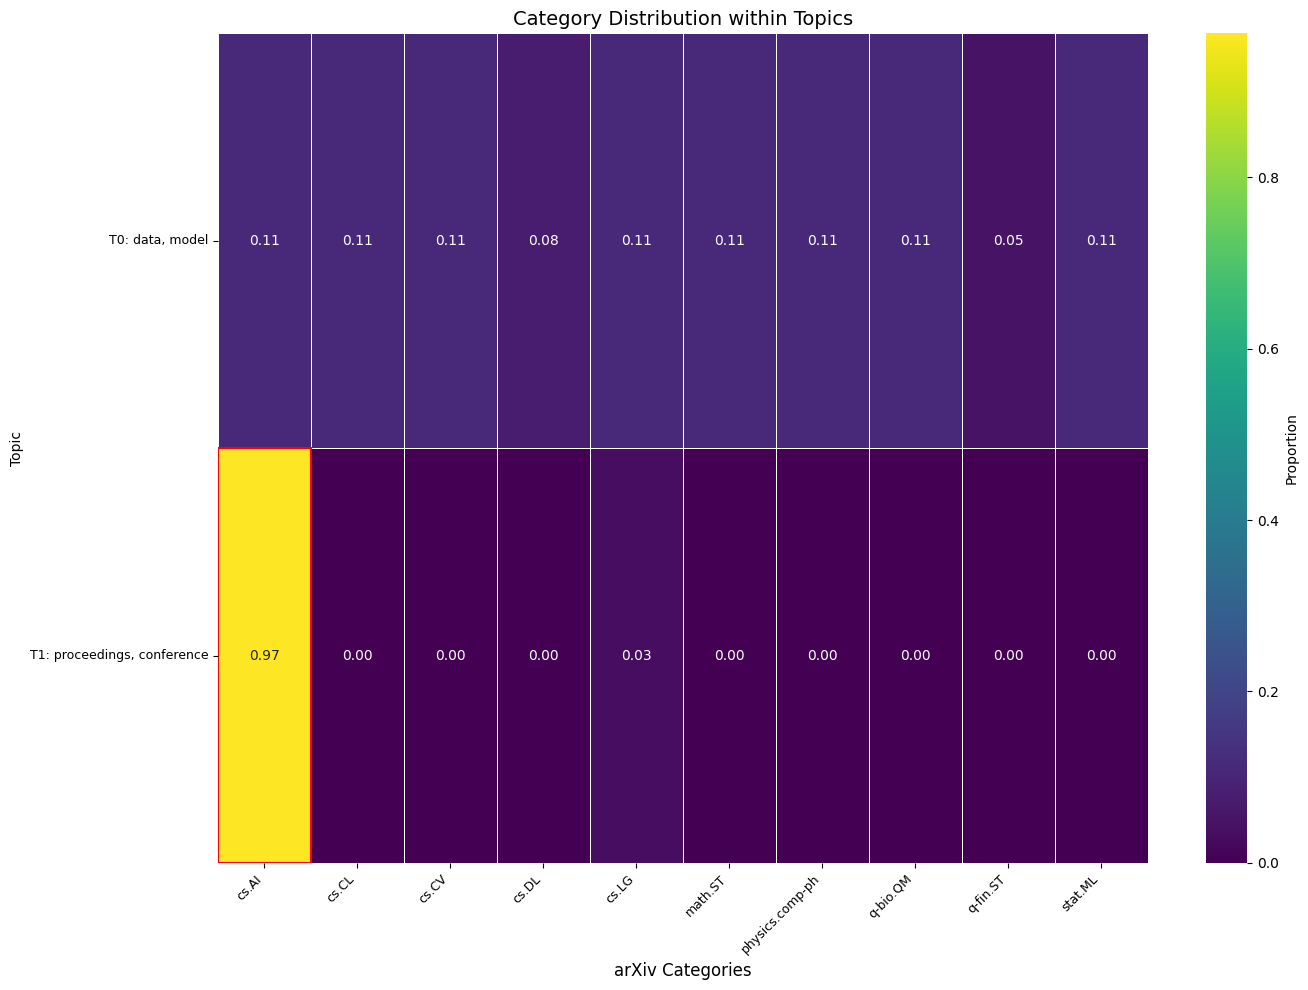

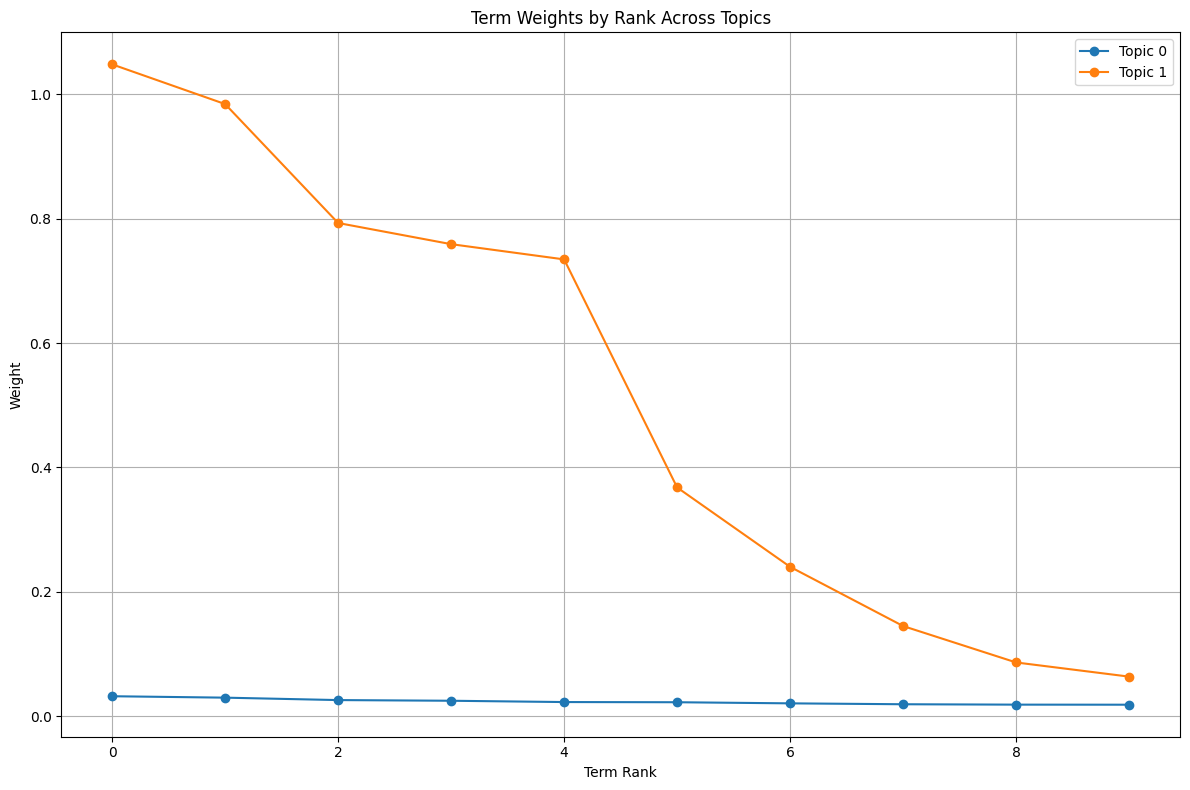

In [16]:
# Step 2: Run baseline experiments with default hyperparameters
print("\n[Step 2]: Running baseline experiments with default hyperparameters")
results = run_experiments(data)

In [17]:
# Step 3: Create comparative visualizations
print("\n[Step 3]: Creating comparative visualizations")
create_comparison_plots(results)


[Step 3]: Creating comparative visualizations


In [18]:
# Step 4: Save evaluation results
print("\n[Step 4]: Saving evaluation results")
save_evaluation_results(results)


[Step 4]: Saving evaluation results
Saved evaluation results to /content/drive/MyDrive/MIDS/W266/final_project//results/


In [19]:
# Step 5: Tune hyperparameters for TopicWeave (optional, can be computationally expensive)
tune_hyperparams = False  # Set to True to run hyperparameter tuning
if tune_hyperparams:
    print("\n[Step 5]: Tuning hyperparameters for TopicWeave")
    tuning_results = tune_hyperparameters(data)

    # Run experiment with optimized hyperparameters
    print("\n[Step a5.1]: Running experiment with optimized hyperparameters")
    optimized_results = run_experiments(data, hyperparams=tuning_results["best_config"])

    # Save optimized results
    print("\n[Step 5.2]: Saving optimized results")
    save_evaluation_results(optimized_results, save_models=True)

print(f"\nTopicWeave Evaluation - Completed at {datetime.now().strftime('%Y-%m-%d %H:%M')}")



TopicWeave Evaluation - Completed at 2025-03-23 18:26
